# Good-bye Pandas! Meet Terality - Its Evil Twin With Identical Syntax
## ... but up to 30 times faster
![](images/unsplash.jpg)

## Setup

In [8]:
import logging
import time
import warnings

import catboost as cb
import datatable as dt
import joblib
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
import umap
import umap.plot
import xgboost as xgb
from optuna.samplers import TPESampler
from sklearn.compose import *
from sklearn.impute import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import *

logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%d-%b-%y %H:%M:%S", level=logging.INFO
)
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")
pd.set_option("float_format", "{:.5f}".format)

In [9]:
def plot_comparison(te_scre, pd_score, title):
    fig, ax = plt.subplots(figsize=(10, 4))

    bars = ax.barh(
        ["Terality", "Pandas"], [te_scre, pd_score], color="black", height=0.4
    )
    ax.bar_label(bars, fontsize=12, fmt="%gs")

    [plt.setp(ax.spines[spine], visible=False) for spine in ax.spines]
    ax.tick_params(
        axis="both",
        which="both",
        left=False,
        bottom=False,
        labelbottom=False,
        labelsize=12,
    )

    ax.set_title(title, size=15, color="#E50914")

    plt.show()

    return fig

# Introduction

As in everything, we are spoilt for choice when working with big data. The number one tool being Pandas, then the likes of Dask, Vaex, Datatable, cuDF, you name it. As if these weren't enough, we now add **Terality** to the list.

Is Terality one of those packages that tries to replace the turtle speed of Pandas at the cost of its so beloved simplicity and flexibility? 

No, Terality is Pandas' evil twin born with superpowers. It has identical syntax with Pandas but works at lightening speed and doesn't depend on your machine to work its magic. 

Sounds too good to be true? Read on. 

## What is Terality and how does it work?

Terality is a serverless data processing engine running on giant clusters. You can work with datasets of any humongous size blazing fast without worrying about scaling resources on the clusters or any infrastructure. 

This means two things:

1. There is virtually no limit on memory, thus on the dataset size.
2. You only need a good Internet connection to process hundreds of GBs even on a 4GB RAM machine.

And the selling point of Terality - its Python package has the exact same syntax as Pandas. You only need to change a single line of code to switch from Pandas to Terality.

![](images/5.png)

The Python package sends HTTPS requests to the Terality engine when you call Pandas functions. The engine processes the data and the command and sends back the result. 

The setup also takes about a minute. You install the library with `pip` and enter your API to hook up your machine to the engine. It is all here in this [link](https://app.terality.com/).

# Preparing a dataset

Pandas was introduced in the January of 2008, when the baby datasets of today was the only thing data scientists had to worry about.

Now, people have to deal with monstrous datasets and they find Pandas lacking the spine to do what it takes to tame such beasts. Terality is here to solve this mounting problem.

To illustrate, we will take a simple dataset ([Kaggle TPS May 2021 dataset](https://www.kaggle.com/c/tabular-playground-series-may-2021/data)) and sample it so that it has 60 million rows and 18 columns.

```python
import pandas as pd

df = pd.read_csv("data/train.csv")

large_df = df.sample(6 * 10 ** 7, replace=True)  # 60 million rows

large_df.to_parquet(
    "data/tps_may_large.parquet", row_group_size=len(df) // 15, engine="pyarrow"
)
```

We save the data as a Parquet format because writing it to a CSV would be too optimistic to the point of foolishness. The file will be about 7 GBs, still pretty small by today's standards:

In [2]:
from pathlib import Path

size = Path("data/tps_may_large.parquet").stat().st_size
size_in_gb = size / 1024 ** 3

round(size_in_gb, 2)

7.1

## Pandas vs. Terality - loading data

We will start the speed comparison with loading the Parquet file into our workspace. 

The performance of Pandas will heavily depend on the CPU of your machine. Mine is AMD Ryzen 9 3900X with 12 cores -  a pretty high-end processor, faster than Google Colab's or Kaggle servers' free CPUs. So, you can expect my machine to put up a good fight against Terality's virtual servers. 

As Terality has the same syntax as Pandas, I will ditch the code examples when unnecessary.

```python

import pandas as pd

%%time

df = pd.read_parquet("data/tps_may_large.parquet")
```

I read the data from local memory with Pandas. 

As for Terality, I read the data from Amazon S3 bucket:

```python
import terality as te

%%time

df_te = te.read_parquet("s3://sample-bucket-for-medium/tps_may_large.parquet")
```

Even though you can work with local files, Terality pairs best with files on Amazon S3 or Google Cloud. 

I've already mentioned the reason for this - the speed of Terality depends on not the CPU but your Internet speed. Reading the Parquet file from memory would mean sending 7GB of data to the engine, which is not ideal. 

The Internet speed is lousy in my country, so S3 bucket it is. Here are the results:

![](images/loading.png)

For now, Terality is slightly behind mainly because of my Internet speed and the power of my CPU. Let's perform other common computation-heavy operations to make further comparison.

In [3]:
import pandas as pd

In [4]:
%%time

df = pd.read_parquet("data/tps_may_large.parquet")
df.head()

Wall time: 1min 19s


,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
182422,304374,B,I,C,A,E,BI,A,E,AE,...,0.314827,0.337578,0.588459,0.812049,0.399413,0.347415,0.362455,0.479648,0.388591,0
293498,489146,A,I,F,A,H,BI,A,AD,AT,...,0.785501,0.262564,0.797093,0.618762,0.685029,0.516098,0.698928,0.647654,0.393393,0
220335,367472,B,I,A,C,F,AB,A,AH,AY,...,0.472732,0.274317,0.239821,0.734716,0.477748,0.458747,0.339953,0.565235,0.417390,0
215241,358783,A,I,A,A,H,BI,A,AN,AD,...,0.866463,0.745388,0.668823,0.619450,0.547709,0.828951,0.815386,0.363989,0.638822,0
265936,443252,A,J,C,A,E,T,A,A,AX,...,0.308595,0.309102,0.803394,0.299911,0.554340,0.332101,0.243223,0.257364,0.314352,0


In [5]:
import terality as te

In [6]:
%%time

df_te = te.read_parquet("s3://sample-bucket-for-medium/tps_may_large.parquet")
df_te.head()

INFO:terality:The result of te.read_parquet was retrieved from cache [docs: https://docs.terality.com/getting-terality/user-guide/caching].
INFO:terality:The result of te.dataframe.head was retrieved from cache [docs: https://docs.terality.com/getting-terality/user-guide/caching].


Wall time: 20.7 s


INFO:terality:The result of te.dataframe._repr_html_ was retrieved from cache [docs: https://docs.terality.com/getting-terality/user-guide/caching].


,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
182422,304374,B,I,C,A,E,BI,A,E,AE,A,DP,A,A,A,A,B,D,D,B,0.282072,0.290521,0.314827,0.337578,0.588459,0.812049,0.399413,0.347415,0.362455,0.479648,0.388591,0
293498,489146,A,I,F,A,H,BI,A,AD,AT,A,HK,A,A,A,A,B,B,D,B,0.389077,0.927745,0.785501,0.262564,0.797093,0.618762,0.685029,0.516098,0.698928,0.647654,0.393393,0
220335,367472,B,I,A,C,F,AB,A,AH,AY,A,MS,A,A,A,A,D,D,D,B,0.487649,0.453483,0.472732,0.274317,0.239821,0.734716,0.477748,0.458747,0.339953,0.565235,0.417390,0
215241,358783,A,I,A,A,H,BI,A,AN,AD,E,HQ,A,A,A,B,A,D,D,B,0.642140,0.786709,0.866463,0.745388,0.668823,0.619450,0.547709,0.828951,0.815386,0.363989,0.638822,0
265936,443252,A,J,C,A,E,T,A,A,AX,A,DP,A,A,A,A,A,D,D,B,0.271567,0.194787,0.308595,0.309102,0.803394,0.299911,0.554340,0.332101,0.243223,0.257364,0.314352,0


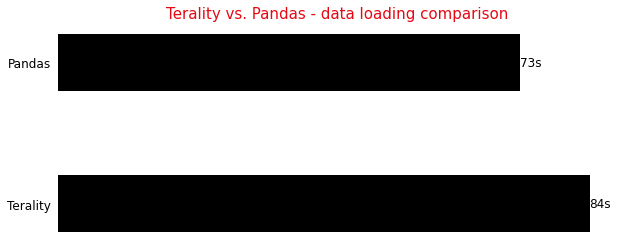

In [21]:
fig = plot_comparison(84, 73, "Terality vs. Pandas - data loading comparison")
fig.savefig("images/loading.png")

## Common pandas operations

Before I show my local results, let's take a look at how Terality performed against Pandas and its powerful alternatives on the well-known [h2o benchmark](https://h2oai.github.io/db-benchmark/) using a 50GB dataset. 

Here is the result for an advanced groupby operation:

![](images/1.png)
<figcaption style="text-align: center;">
    <strong>
        Image taken with permission from 
        <a href='https://www.terality.com/post/terality-beats-spark-and-dask-h2o-benchmark'>the benchmark test post on Terality website.</a>
    </strong>
</figcaption>

As you can see, only Terality manages to keep its wits together while others spurt out nasty memory errors. The same is true for a join operation:

![](images/2.png)
<figcaption style="text-align: center;">
    <strong>
        Image taken with permission from 
        <a href='https://www.terality.com/post/terality-beats-spark-and-dask-h2o-benchmark'>the benchmark test post on Terality website.</a>
    </strong>
</figcaption>

Of course, not all have the luxury of 128GB machines, so I will just show the experiments on my humble 32 GB one:

#### Grouping

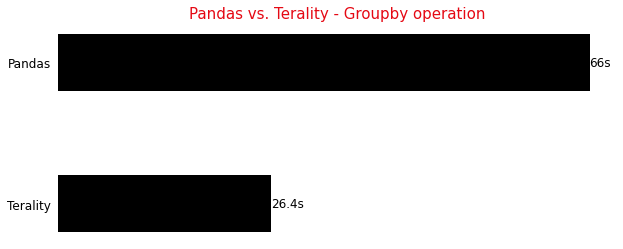

In [22]:
fig = plot_comparison(26.4, 66, "Pandas vs. Terality - Groupby operation")
fig.savefig("images/groupby.png")

#### Sorting

![](images/sorting.png)

In [24]:
%%time

result = df.sort_values(by="cont5", ascending=False)
result.head()

Wall time: 3min 20s


,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
179851,300051,B,F,A,B,G,BI,C,AS,A,...,0.43100,0.26179,0.71291,0.85302,0.76067,0.41565,0.60751,0.26465,0.42208,0
179851,300051,B,F,A,B,G,BI,C,AS,A,...,0.43100,0.26179,0.71291,0.85302,0.76067,0.41565,0.60751,0.26465,0.42208,0
179851,300051,B,F,A,B,G,BI,C,AS,A,...,0.43100,0.26179,0.71291,0.85302,0.76067,0.41565,0.60751,0.26465,0.42208,0
179851,300051,B,F,A,B,G,BI,C,AS,A,...,0.43100,0.26179,0.71291,0.85302,0.76067,0.41565,0.60751,0.26465,0.42208,0
179851,300051,B,F,A,B,G,BI,C,AS,A,...,0.43100,0.26179,0.71291,0.85302,0.76067,0.41565,0.60751,0.26465,0.42208,0


In [25]:
%%time

result = df_te.sort_values(by="cont5", ascending=False)
result.head()

Wall time: 58.3 s


,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
179851,300051,B,F,A,B,G,BI,C,AS,A,A,GS,A,A,A,A,C,C,D,C,0.340314,0.707281,0.431003,0.261791,0.712914,0.853022,0.76067,0.415646,0.607509,0.264648,0.422077,0
179851,300051,B,F,A,B,G,BI,C,AS,A,A,GS,A,A,A,A,C,C,D,C,0.340314,0.707281,0.431003,0.261791,0.712914,0.853022,0.76067,0.415646,0.607509,0.264648,0.422077,0
179851,300051,B,F,A,B,G,BI,C,AS,A,A,GS,A,A,A,A,C,C,D,C,0.340314,0.707281,0.431003,0.261791,0.712914,0.853022,0.76067,0.415646,0.607509,0.264648,0.422077,0
179851,300051,B,F,A,B,G,BI,C,AS,A,A,GS,A,A,A,A,C,C,D,C,0.340314,0.707281,0.431003,0.261791,0.712914,0.853022,0.76067,0.415646,0.607509,0.264648,0.422077,0
179851,300051,B,F,A,B,G,BI,C,AS,A,A,GS,A,A,A,A,C,C,D,C,0.340314,0.707281,0.431003,0.261791,0.712914,0.853022,0.76067,0.415646,0.607509,0.264648,0.422077,0


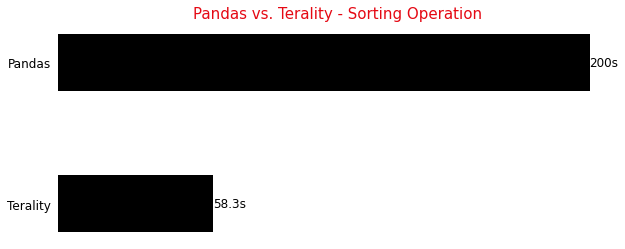

In [23]:
fig = plot_comparison(58.3, 200, "Pandas vs. Terality - Sorting Operation")

fig.savefig("images/sorting.png")

#### Creating a new column

![](images/new_col.png)

In [34]:
%%time

df["new"] = df["cont0"].apply(lambda x: np.sqrt(np.exp(x)))
df["new"].sample(5)

Wall time: 2min 25s


145053   1.40283
286303   1.27540
103920   1.16384
85100    1.29126
216857   1.17710
Name: new, dtype: float64

In [35]:
%%time

df_te["new"] = df_te["cont0"].apply(lambda x: np.sqrt(np.exp(x)))
df_te["new"].sample(5)

Wall time: 1min 11s


64783     1.263485
260467    1.046370
245600    1.321468
269796    1.312624
192964    1.072801
Name: new, dtype: float64

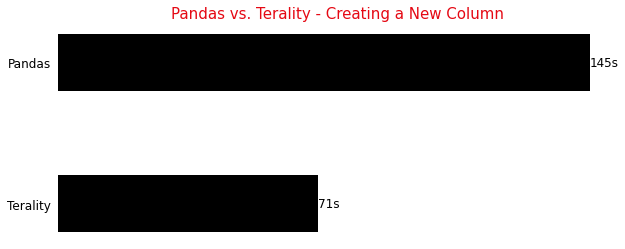

In [24]:
fig = plot_comparison(71, 145, "Pandas vs. Terality - Creating a New Column")
fig.savefig("images/new_col.png")

#### Replacing

![](images/replacing.png)

In [15]:
%%time

df.replace(["A", "B", "C"], ["AA", "BB", "CC"], inplace=True)

Wall time: 2min 5s


In [16]:
%%time

df_te.replace(["A", "B", "C"], ["AA", "BB", "CC"], inplace=True)

Wall time: 40.3 s


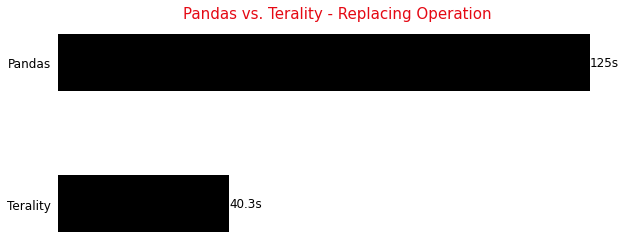

In [25]:
fig = plot_comparison(40.3, 125, "Pandas vs. Terality - Replacing Operation")
fig.savefig("images/replacing.png")

As I've said, my machine fought well but still lost in all operations.

## Notes on syntax

Even though Terality has identical syntax, some of Pandas' functions aren't yet implemented. 

You can expect about 80-90% of all the methods of DataFrames and Series to work on Terality DataFrames as well. Most of the functions in the global Pandas namespace (the ones called with `pd.some_function`) also work. Considering that Terality is still in beta, this is no small feat.